In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from fuzzywuzzy import process

In [2]:
movies_data = pd.read_csv('/kaggle/input/movie-lens-dataset/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies_data['genres'] = movies_data['genres'].str.split('|')
movies_data['genres'] = movies_data['genres'].fillna('').astype('str')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II (1995),['Comedy']


# Content Base

In [4]:
def tf_idf_matrix(movies_dataset):
    tf_idf = TfidfVectorizer(analyzer = 'word', ngram_range=(1,1), min_df=0)
    tfidf_matrix = tf_idf.fit_transform(movies_dataset['genres'])
    return tfidf_matrix
tf_matrix = tf_idf_matrix(movies_data)
tf_matrix.shape[0]

9742

In [5]:
def cosin(matrix):
    _cosin = linear_kernel(matrix, matrix)
    return _cosin
cosin_matrix = cosin(tf_matrix)
len(cosin_matrix)

9742

In [6]:
indices = pd.Series(movies_data.index, index=movies_data['title'])
def pred(title, top_x, cosin_matrix):
    idx = process.extractOne(title, movies_data['title'])[2]
    sim_scores = list(enumerate(cosin_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(top_x+1)]
    movie_indices = [i[0] for i in sim_scores]
    topMovies = movies_data['title'].iloc[movie_indices]
    movie_ratings = [i[1] for i in sim_scores]
    topMovies['Score'] = movie_ratings
    return  topMovies

In [7]:
topMovies = pred('toy story', 10, cosin_matrix)

print(topMovies)

print("--------------Scores---------------------------")
print(topMovies['Score'])

titles = np.array(topMovies)[0:10]
score = np.array(topMovies['Score'])


1706                                           Antz (1998)
2355                                    Toy Story 2 (1999)
2809        Adventures of Rocky and Bullwinkle, The (2000)
3000                      Emperor's New Groove, The (2000)
3568                                 Monsters, Inc. (2001)
6194                                      Wild, The (2006)
6486                                Shrek the Third (2007)
6948                        Tale of Despereaux, The (2008)
7760     Asterix and the Vikings (Astérix et les Viking...
8219                                          Turbo (2013)
Score    [0.9999999999999998, 0.9999999999999998, 0.999...
Name: title, dtype: object
--------------Scores---------------------------
[0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998]


# Collaboration Filtering


In [8]:
link_data = pd.read_csv('/kaggle/input/movie-lens-dataset/links.csv')
link_data.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
ratings_data = pd.read_csv('/kaggle/input/movie-lens-dataset/ratings.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
tags_data = pd.read_csv('/kaggle/input/movie-lens-dataset/tags.csv')
tags_data.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
movie_user = ratings_data.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [12]:
num_users = len(ratings_data.userId.unique())
num_items = len(ratings_data.movieId.unique())
print(num_users)
print(num_items)

610
9724


In [13]:
df_ratings_cnt_tmp = pd.DataFrame(ratings_data.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [14]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings_data.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [15]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

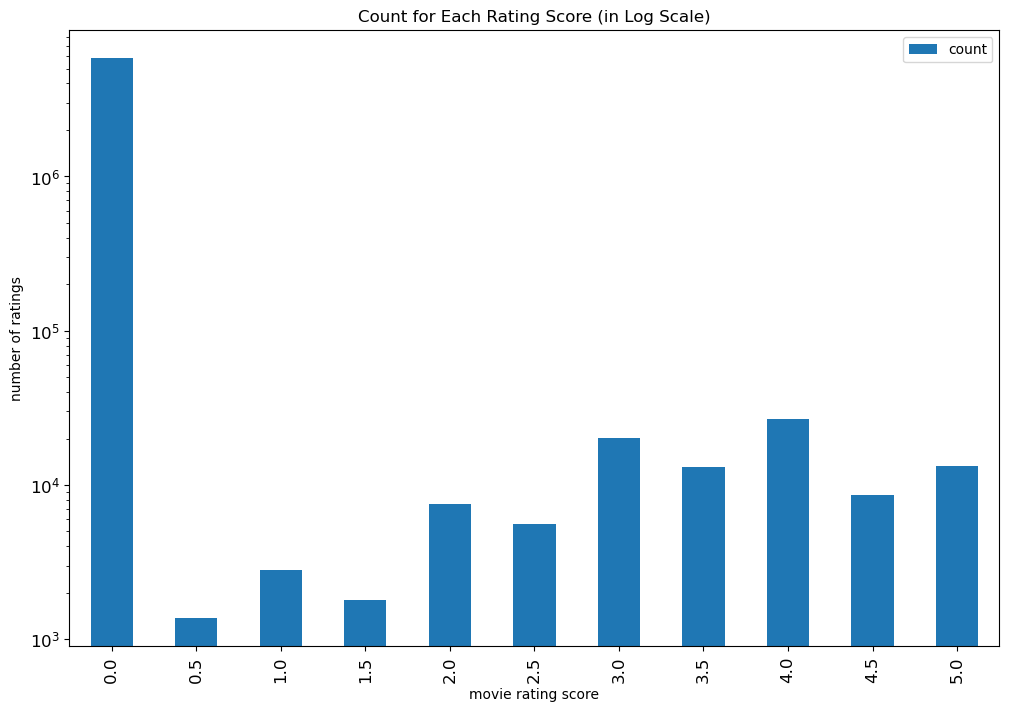

In [16]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [17]:
movie_user

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
mat_movie = csr_matrix(movie_user.values)

In [19]:
model = NearestNeighbors(metric='cosine', algorithm='brute',n_neighbors=20)
model.fit(mat_movie)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [20]:
def pred(title, data, top_x):
    idx = process.extractOne(title, movies_data['title'])[2]
    dist, indices = model.kneighbors(data[idx], n_neighbors=top_x)
    for i in indices:
        print(movies_data['title'][i].where(i!=idx))

In [21]:
pred('Toy Story', mat_movie, 10)

0                                                     NaN
2353                                 'night Mother (1986)
418                                  Jurassic Park (1993)
615                  Independence Day (a.k.a. ID4) (1996)
224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
322                                 Lion King, The (1994)
910     Once Upon a Time in the West (C'era una volta ...
546                            Mission: Impossible (1996)
963                                           Diva (1981)
Name: title, dtype: object


# Hybrid